## Measuring g with a Physical Pendulum - Complete
### Load Libraries
Note that I used python uncertainties package to compute uncertainties instead of manual calculation inputting formula.
You would need to do:

**pip install uncertainties**

#### Note, I am splitting the cells in Complete code as suggested based on Lab C feedback (I got feedback after Optimize analysis), but personally I don't like splitting too many cells as suggested and I feel it is much easier for me to look, code, and divide the section by section instead of each cell that compute each small task.. but I sticked to the suggestion as much as possible.

In [1]:
# For scientific computing
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.integrate as integrate

# For plotting
import matplotlib.pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *  #e.g. sqrt()
from uncertainties import unumpy

## 1. Plot of $T$ vs $\theta_0$ (Photogate & Stopwatch)
For this plot, we will investigate the effect of initial angle displacement on the period.

In [2]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global constants
a = 100  # bar dimension 
b = 3.8  # bar dimension 
c = 0.96  # bar dimension 
g_true = 980.665 # true value of earth grav constant cm/s^2
numSmpsPerSec = 1000.0

#uncertainties 
alpha_a = 0.05 # tape measure precision
alpha_b = 0.05  # ruler precision
alpha_c = 0.005  # vernier caliber precision
alpha_l = 0.05 # ruler precision
alpha_T = np.sqrt((1/2*numSmpsPerSec)**2 + (1/2*numSmpsPerSec)**2) # estimated photogate precision


a_ufloat = ufloat(a, alpha_a)
b_ufloat = ufloat(b, alpha_b)
k_dim_ufloat = sqrt( (a_ufloat**2 + b_ufloat**2)/12 )

T_photogate, theta0h, h1, h2, l = np.genfromtxt(f"data/2020-12-01-photogate-angle-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')

T_stopwatch, theta0, h1, h2, l = np.genfromtxt(f"data/2020-12-01-stopwatch-15cycles-angle-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')

N = len(l)

l_ufloat = unumpy.uarray(l, 0.05*np.ones(N))
h1_ufloat = unumpy.uarray(h1, 0.1*np.ones(N))
h2_ufloat = unumpy.uarray(h2, 0.1*np.ones(N))

# this is error propagation when calculating the angle
alpha_theta0 = unumpy.std_devs(unumpy.arccos( (l_ufloat-(h2_ufloat - h1_ufloat))/l_ufloat ) * (180/np.pi))

#number of parameters
n = 2

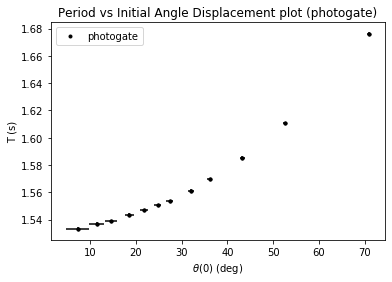

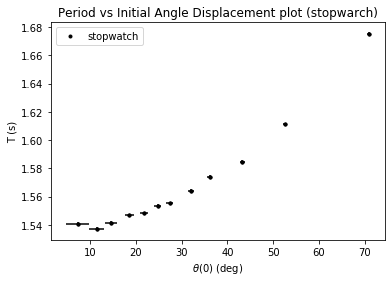

In [3]:
# --------------------------------------------------------------------------------------------------
# Plotting
# --------------------------------------------------------------------------------------------------

plt.plot(theta0, T_photogate, "k.", label="photogate")
plt.errorbar(theta0, T_photogate, xerr=alpha_theta0, yerr=0.001, fmt='k.')
plt.legend(loc='best')
plt.ylabel(r'T (s)')
plt.xlabel(r'$\theta$(0) (deg)')
plt.title(f"Period vs Initial Angle Displacement plot (photogate)")
plt.show()

plt.plot(theta0, T_stopwatch, "k.", label="stopwatch")
plt.errorbar(theta0, T_stopwatch, xerr=alpha_theta0, yerr=0.001, fmt='k.')
plt.legend(loc='best')
plt.ylabel(r'T (s)')
plt.xlabel(r'$\theta$(0) (deg)')
plt.title(f"Period vs Initial Angle Displacement plot (stopwarch)");
plt.show();

## 2. Plot of $T$ vs $l$ (Photogate)

The relationship between T and l we derived is as follows:

$$T = 2\pi \sqrt{\frac{k^2+l^2}{gl}}$$

Estimate k and g directly from the `curve_fit`.

In [4]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global string for labelling
labely = "T (s)"
labelx = "l (cm)"

#global constants
a = 100  # bar dimension 
b = 3.8  # bar dimension 
c = 0.96  # bar dimension 
g_true = 980.665 # true value of earth grav constant cm/s^2
numSmpsPerSec = 1000.0

#uncertainties 
alpha_a = 0.05 # tape measure precision
alpha_b = 0.05  # ruler precision
alpha_c = 0.005  # vernier caliber precision
alpha_l = 0.05 # ruler precision
alpha_T = np.sqrt((1/numSmpsPerSec/2)**2 + (1/numSmpsPerSec/2)**2) # photogate precision

a_ufloat = ufloat(a, alpha_a)
b_ufloat = ufloat(b, alpha_b)
k_dim_ufloat = sqrt( (a_ufloat**2 + b_ufloat**2)/12 )

T, l = np.genfromtxt(f"data/2020-12-01-photogate-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')
N = len(T)

#number of parameters
n = 2
print("alpha_T (original estimate) = ",alpha_T)

alpha_T (original estimate) =  0.0007071067811865475


In [5]:
# --------------------------------------------------------------------------------------------------
# Fitting
# --------------------------------------------------------------------------------------------------

#inputs
x = l
y = T

alpha_x = alpha_l * np.ones(N)
alpha_y = alpha_T * np.ones(N)

def myFunc(x, k, g):
    return 2 * np.pi * np.sqrt((k**2 + x**2) / (g * x))

pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[28.80, 980],
                       sigma=alpha_y,
                       absolute_sigma=True
                       ) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

In [6]:
# ------------------------------------------------------------------------------------
# printing result 
# ------------------------------------------------------------------------------------

# Show optimized fit parameters and uncertainties
print(f"k(computed from dimension) = ({k_dim_ufloat.n:.2f} ± {k_dim_ufloat.s:.2f}) cm")
print(f"g(true) = {g_true:.1f} cm/s^2")
print(f"k = ({p0_opt:.2f} ± {alpha_p0:.2f}) cm")
print(f"g = ({p1_opt:.1f} ± {alpha_p1:.1f}) cm/s^2")

k_exp_ufloat = ufloat(p0_opt, alpha_p0)
g_ufloat = ufloat(p1_opt, alpha_p1)
T_min_true = 2 * np.pi * np.sqrt( (2 * k_dim_ufloat.n)/ g_true)
T_min_ufloat = 2 * np.pi * sqrt( (2 * k_exp_ufloat)/ g_ufloat)
print(f"Tmin(true) = {T_min_true:.2f}")
print(f"Tmin(experimental) = {T_min_ufloat:.3f}")

k(computed from dimension) = (28.89 ± 0.01) cm
g(true) = 980.7 cm/s^2
k = (28.80 ± 0.03) cm
g = (978.3 ± 1.0) cm/s^2
Tmin(true) = 1.53
Tmin(experimental) = 1.525+/-0.001


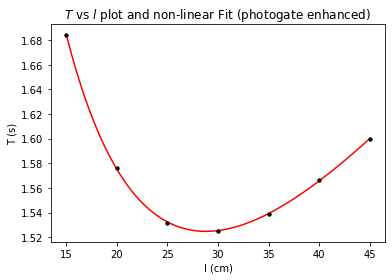

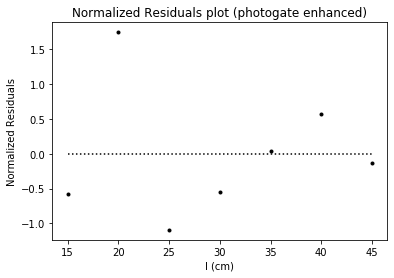

In [7]:
# ---------------------------------------------------------------
# plotting
# ---------------------------------------------------------------

#Plot data
plt.plot(x, y, 'k.')
x_model = np.linspace(np.min(x),np.max(x),100)
plt.plot(x_model, myFunc(x_model, p0_opt, p1_opt), 'r-')
plt.errorbar(x, y, xerr=alpha_x, yerr=alpha_y, fmt='k.')
plt.xlabel(f'{labelx}')
plt.ylabel(f'{labely}')
plt.title(r'$T$ vs $l$ plot and non-linear Fit (photogate enhanced)')
plt.show()

# Plot the residuals in a separate figure
plt.plot(x, (y - myFunc(x, p0_opt, p1_opt))/alpha_y, 'k.')
plt.plot([np.min(x), np.max(x)], [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format
plt.xlabel(f"{labelx}")
plt.ylabel('Normalized Residuals')
plt.title(f'Normalized Residuals plot (photogate enhanced)')
plt.show()

## 2. Chi-square Analysis (photogate)

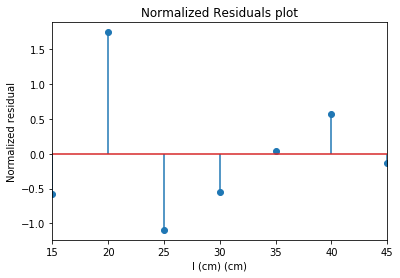

In [8]:
# --------------------------------------------------------------------------------------------------
# Chi-square analysis
# --------------------------------------------------------------------------------------------------
# Compute and display chi-squared minimum
dof = len(x) - n
res = y - myFunc(x, p0_opt, p1_opt)
normres = res/alpha_y
chisq = np.sum(normres**2)
reduced_chisq = chisq / dof
cdf = chi2.cdf(chisq, dof) # Compute the probability of getting this fit result

# plotting result
plt.stem(x, normres, use_line_collection=True)
plt.xlabel(f'{labelx} (cm)')
plt.ylabel('Normalized residual')
plt.title(f'Normalized Residuals plot')
plt.xlim(np.min(x), np.max(x))
plt.show()

In [9]:
# -------------------------------------------------------------------------
# printing result 
# -------------------------------------------------------------------------
print(f"degree of freedom dof = {dof}")
print(f"chisq_min = {chisq:.5f}")
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

if (chisq > dof - np.sqrt(2 * dof) and chisq < dof + np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is within the 1*sigma range")
elif (chisq > dof - 2*np.sqrt(2 * dof) and chisq < dof + 2*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [{dof - 2*np.sqrt(2 * dof)}, {dof + 2*np.sqrt(2 * dof)}], so our model is within the 2*sigma range")
elif (chisq > dof - 3*np.sqrt(2 * dof) and chisq < dof + 3*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - 3*np.sqrt(2 * dof)}, {dof + 3*np.sqrt(2 * dof)}], so our model is within the 3*sigma range")
else:
    print(f"chisq_min is not within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - np.sqrt(3 * dof)}, {dof + np.sqrt(3 * dof)}], so our model is not within the 3*sigma range")
    print(f"null hypothesis is rejected; our model is not accepted.")

degree of freedom dof = 5
chisq_min = 5.18701
Cumulative probability = 0.606513
Significance: 0.393487
chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [1.8377223398316205, 8.16227766016838], so our model is within the 1*sigma range


## 3. Estimating Error Using Scaling Factor

In [10]:
print(f"Use scaling factor to estimate the error.")
S = np.sqrt(chisq/dof)
print(f"scaling factor = {S}")

Use scaling factor to estimate the error.
scaling factor = 1.0185288432998927


## 4. Final Plot of $T$ vs $l$ (Photogate with estimated $\alpha_T$)

In [11]:
# -------------------------------------------------------------------------------
# inputs 
# -------------------------------------------------------------------------------
x = l
y = T

alpha_x = alpha_l * np.ones(N)
alpha_y = alpha_T * np.ones(N) * S
print("Original estimated error of period (pure sampling error): " ,np.sqrt((1/1000/2)**2 + (1/1000/2)**2))
print("Estimated true value of error of period: ", alpha_y[0])

Original estimated error of period (pure sampling error):  0.0007071067811865475
Estimated true value of error of period:  0.0007202086519314446


In [12]:
pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[28.89, 980],
                       sigma=alpha_y,
                       absolute_sigma=True
                       ) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

In [13]:
# ------------------------------------------------------------------------------------
# printing result 
# ------------------------------------------------------------------------------------

# Show optimized fit parameters and uncertainties
print(f"k(computed from dimension) = ({k_dim_ufloat.n:.2f} ± {k_dim_ufloat.s:.2f}) cm")
print(f"g(true) = {g_true:.1f} cm/s^2")
print(f"k = ({p0_opt:.2f} ± {alpha_p0:.2f}) cm")
print(f"g = ({p1_opt:.1f} ± {alpha_p1:.1f}) cm/s^2")

k_exp_ufloat = ufloat(p0_opt, alpha_p0)
g_ufloat = ufloat(p1_opt, alpha_p1)
T_min_true = 2 * np.pi * np.sqrt( (2 * k_dim_ufloat.n)/ g_true)
T_min_ufloat = 2 * np.pi * sqrt( (2 * k_exp_ufloat)/ g_ufloat)
print(f"Tmin(true) = {T_min_true:.2f}")
print(f"Tmin(experimental) = {T_min_ufloat:.3f}")

k(computed from dimension) = (28.89 ± 0.01) cm
g(true) = 980.7 cm/s^2
k = (28.80 ± 0.03) cm
g = (978.3 ± 1.1) cm/s^2
Tmin(true) = 1.53
Tmin(experimental) = 1.525+/-0.001


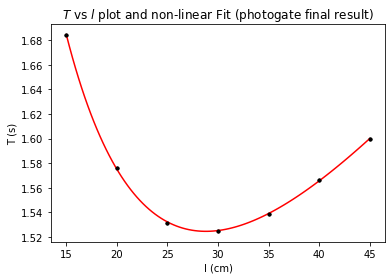

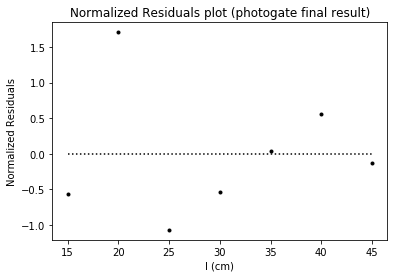

In [14]:
# ---------------------------------------------------------------
# plotting
# ---------------------------------------------------------------

#Plot data
plt.plot(x, y, 'k.')
x_model = np.linspace(np.min(x),np.max(x),100)
plt.plot(x_model, myFunc(x_model, p0_opt, p1_opt), 'r-')
plt.errorbar(x, y, xerr=alpha_x, yerr=alpha_y, fmt='k.')
plt.xlabel(f'{labelx}')
plt.ylabel(f'{labely}')
plt.title(r'$T$ vs $l$ plot and non-linear Fit (photogate final result)')
plt.show()

# Plot the residuals in a separate figure
plt.plot(x, (y - myFunc(x, p0_opt, p1_opt))/alpha_y, 'k.')
plt.plot([np.min(x), np.max(x)], [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format
plt.xlabel(f"{labelx}")
plt.ylabel('Normalized Residuals')
plt.title(f'Normalized Residuals plot (photogate final result)')
plt.show()

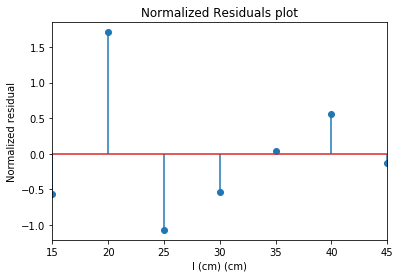

In [15]:
# --------------------------------------------------------------------------------------------------
# Chi-square analysis
# --------------------------------------------------------------------------------------------------
# Compute and display chi-squared minimum
dof = len(x) - n
res = y - myFunc(x, p0_opt, p1_opt)
normres = res/alpha_y
chisq = np.sum(normres**2)
reduced_chisq = chisq / dof
cdf = chi2.cdf(chisq, dof) # Compute the probability of getting this fit result

# plotting result
plt.stem(x, normres, use_line_collection=True)
plt.xlabel(f'{labelx} (cm)')
plt.ylabel('Normalized residual')
plt.title(f'Normalized Residuals plot')
plt.xlim(np.min(x), np.max(x))
plt.show()

In [16]:
# -------------------------------------------------------------------------
# printing result 
# -------------------------------------------------------------------------
print(f"degree of freedom dof = {dof}")
print(f"chisq_min = {chisq:.5f}")
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

if (chisq > dof - np.sqrt(2 * dof) and chisq < dof + np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is within the 1*sigma range")
elif (chisq > dof - 2*np.sqrt(2 * dof) and chisq < dof + 2*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [{dof - 2*np.sqrt(2 * dof)}, {dof + 2*np.sqrt(2 * dof)}], so our model is within the 2*sigma range")
elif (chisq > dof - 3*np.sqrt(2 * dof) and chisq < dof + 3*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - 3*np.sqrt(2 * dof)}, {dof + 3*np.sqrt(2 * dof)}], so our model is within the 3*sigma range")
else:
    print(f"chisq_min is not within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - np.sqrt(3 * dof)}, {dof + np.sqrt(3 * dof)}], so our model is not within the 3*sigma range")
    print(f"null hypothesis is rejected; our model is not accepted.")

degree of freedom dof = 5
chisq_min = 5.00000
Cumulative probability = 0.584120
Significance: 0.415880
chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [1.8377223398316205, 8.16227766016838], so our model is within the 1*sigma range
